In [63]:
import os
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import regularizers

In [64]:
train_data_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

In [65]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size= IMG_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
)

Found 11230 images belonging to 6 classes.


In [66]:
validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size= IMG_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 2804 images belonging to 6 classes.


In [67]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size= IMG_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
)

Found 3000 images belonging to 6 classes.


In [68]:
def display_images_per_category(generator, categories, images_per_category=3):
    # Dictionary to store images for each category
    category_images = {category: [] for category in categories}
    
    # Iterate over the dataset to fetch images
    for images, labels in generator:
        for i, label in enumerate(labels):
            category = categories[np.argmax(label)]
            if len(category_images[category]) < images_per_category:
                category_images[category].append(images[i])
        
        # Stop when we have enough images for each category
        if all(len(imgs) >= images_per_category for imgs in category_images.values()):
            break

    # Plot the images
    num_categories = len(categories)
    plt.figure(figsize=(num_categories * 2, images_per_category * 2))
    
    for col_idx, category in enumerate(categories):
        for row_idx in range(images_per_category):
            # Only plot if there are enough images
            if row_idx < len(category_images[category]):
                plt.subplot(images_per_category, num_categories, row_idx * num_categories + col_idx + 1)
                plt.imshow(category_images[category][row_idx])
                plt.axis('off')
                
                # Show category name at the top of the first row
                if row_idx == 0:
                    plt.title(category)
    
    plt.tight_layout()
    plt.show()

In [ ]:
category_names = list(train_generator.class_indices.keys())
display_images_per_category(train_generator,category_names,images_per_category = 3)

In [70]:
input_shape = train_generator.image_shape
category_count = len(category_names)

In [71]:
class AlexNet(Sequential):
    def __init__(self, input_shape, nb_classes, l2 = 0.001):
        super().__init__()
        self.add(Input(shape=input_shape)),
        self.add(Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(l2)))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
        self.add(ZeroPadding2D(padding=2))
        self.add(Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
        self.add(Conv2D(384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2)))
        self.add(Conv2D(384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2)))
        self.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(l2)))
        self.add(Flatten())
        self.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(l2)))
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(l2)))
        self.add(Dropout(0.5))
        self.add(Dense(nb_classes, activation='softmax'))
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 875,
            decay_rate = 0.95
        )
        
        adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
        self.summary()

In [72]:
alex_net = AlexNet(input_shape, category_count)

Model: "alex_net_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 35, 35, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 21, 21, 96)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 17, 17, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    67,112,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,666,054 (334.42 MB)

 Trainable params: 87,666,054 (334.42 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
class Model:
    def __init__(self, model, batch_size):
        self.model = model
        self.batch_size = batch_size
        
    def train(self,train_data, epochs = 50):
        history = self.model.fit(
              train_data,
              steps_per_epoch= train_data.samples // self.batch_size,
              validation_data=validation_generator,
              validation_steps=validation_generator.samples // self.batch_size,
              epochs= epochs)
        
        return history;
        
    def evaluate(self, data):
        loss, acc = self.model.evaluate(data)
        print(f"acc: {acc}, loss: {loss}")
        

In [74]:
def plot_accuracy_values(history):
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

In [75]:
model = Model(alex_net, BATCH_SIZE)

In [76]:
history = model.train(train_generator, epochs = 25)

Epoch 1/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 413ms/step - accuracy: 0.3938 - loss: 10.7458 - val_accuracy: 0.6432 - val_loss: 4.9786
Epoch 2/25
  1/175 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.6562 - loss: 5.0567

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6562 - loss: 5.0567 - val_accuracy: 0.6731 - val_loss: 4.8841
Epoch 3/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.6107 - loss: 4.5235 - val_accuracy: 0.6940 - val_loss: 3.3965
Epoch 4/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - accuracy: 0.6094 - loss: 3.6352 - val_accuracy: 0.7115 - val_loss: 3.2478
Epoch 5/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.6853 - loss: 3.2127 - val_accuracy: 0.7344 - val_loss: 2.6752
Epoch 6/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - accuracy: 0.6406 - loss: 2.8286 - val_accuracy: 0.8077 - val_loss: 2.4717
Epoch 7/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.7435 - loss: 2.5335 - val_accuracy: 0.7144 - val_loss: 2.3510
Epoch 8/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - accuracy: 0.7500 - loss: 2.2418 - val_accuracy: 0.7500 - val_loss: 2.2059
Epoch 9/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.7533 - loss: 2.1623 - val_accu

In [77]:
model.model.evaluate(validation_generator)

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8380 - loss: 0.9957


[0.9954342246055603, 0.8388017416000366]

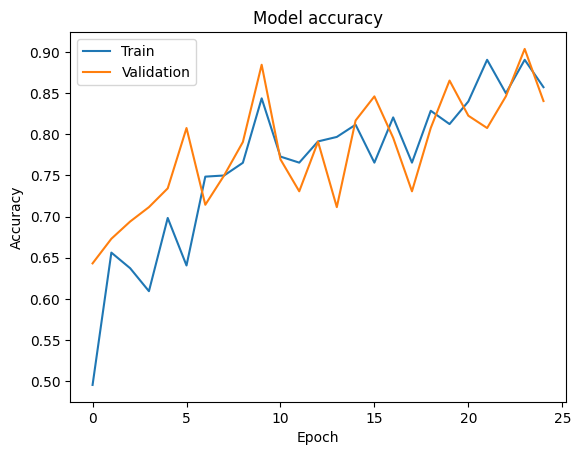

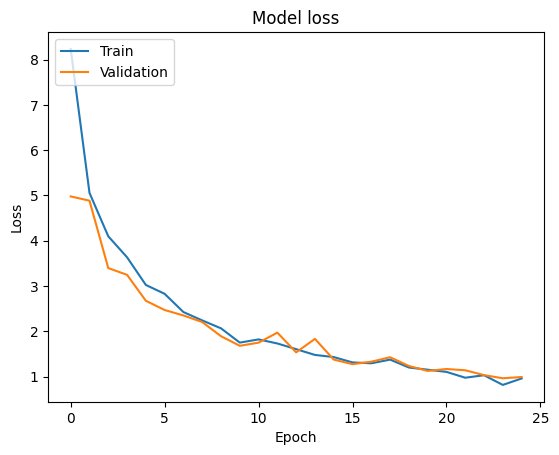

In [81]:
plot_accuracy_values(history)

In [82]:
test_loss, test_acc = model.model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8418 - loss: 1.0107
Test accuracy: 0.8400135636329651
Test loss: 0.9967562556266785


In [83]:
predictions = model.model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
predicted_classes = predictions.argmax(axis=-1)

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step


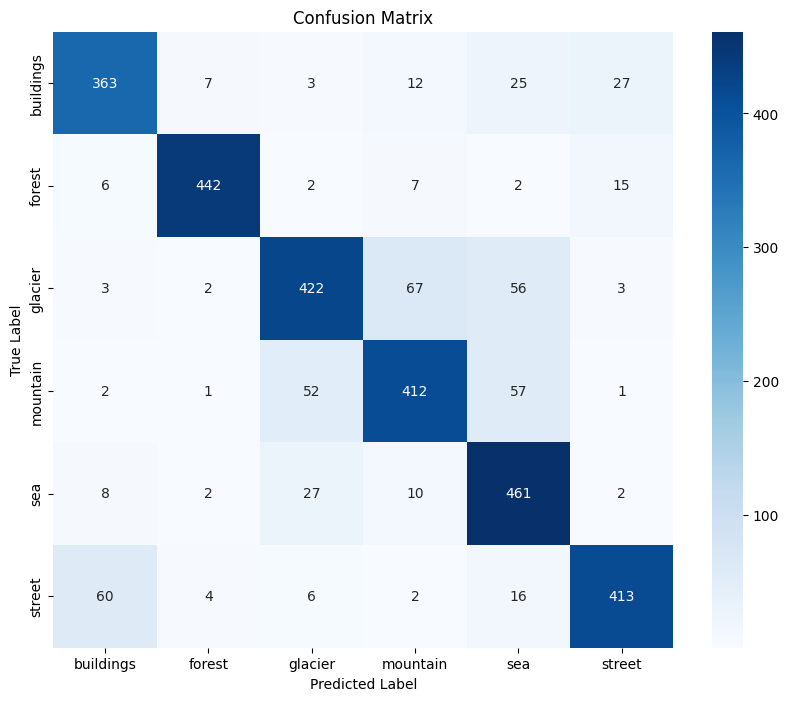

In [84]:
predictions = model.model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()